In [36]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import constants as cs
import Dates as dates 
import payoff as pf

%reload_ext autoreload
%autoreload 2



In [ ]:

def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.data_startdate: cs.data_enddate]
    return data 

data = getdata()

data



In [ ]:
def multi_asset_gbm(data: pd.DataFrame) -> pd.DataFrame:
    
    try:
        log_returns_list = []
        for ticker in cs.ticker_list:
            log_returns = np.log(data[ticker]/data[ticker].shift(1))
            log_returns.dropna(inplace = True) # A series
            log_returns_list.append(log_returns)
        
    except Exception as e:
        raise Exception("Error at generating log return.")


    try: 
        cov_matrix = np.cov(np.array(log_returns_list))
        L = np.linalg.cholesky(cov_matrix)
        
    except Exception as e:
        raise Exception("Error at covariance matrix.")
    
    
    
  
    try: 
        sim_data = pd.DataFrame(np.zeros((cs.window_len, cs.num_ticker)), columns = cs.ticker_list)
        st_vector = data.loc[str(cs.initial_fixing_date)]
        z_list = np.random.normal(0, 1, (cs.num_ticker, cs.window_len))
        for t in range(cs.window_len):
            Z = z_list[:,t]
            for i in range(cs.num_ticker):
                LZ = np.dot(L, Z.T)
                st_vector[i] = st_vector[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
                sim_data.loc[t, cs.ticker_list[i]] = st_vector[i]

    except Exception as e:
        raise Exception("Error at simulating.")
    
    #formatting Dates 
    dates = pd.date_range(cs.initial_fixing_date, cs.final_fixing_date)
    sim_data.index = dates
    sim_data.columns = cs.sim_ticker

    return sim_data



sim_data= multi_asset_gbm(data=data)

    


In [ ]:
fig, ax = plt.subplots()
realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
realised_price.plot(ax=ax)
sim_data.plot(ax=ax)

In [ ]:
def rolling_window(r: pd.DataFrame, window_len: int,  window_end: list):
   
    windows = [(end - pd.offsets.BusinessDay(n=window_len), end) for end in window_end]
    data_vectors_windows = []
    for window in windows: 
        data_in_window = r.loc[str(window[0]) : str(window[1])]
        data_vectors_windows.append(data_in_window)
    return data_vectors_windows
    


rolling_window(r = data, window_len=60, window_end = pd.bdate_range(str(cs.initial_fixing_date), str(cs.final_fixing_date)))

In [ ]:
def multi_asset_gbm_n_sims(plot : bool, plotasset : bool) -> pd.DataFrame:
    sim_data_combine = pd.DataFrame()
    Z_list = np.random.normal(0,1,(cs.num_ticker, cs.window_len))

    realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    for sim in range(cs.n_sims):
        simdata= multi_asset_gbm(data=data)
        sim_data_combine= pd. concat([sim_data_combine, simdata], axis = 1)

        
        if plot == True: 
            fig, ax = plt.subplots()
            
            realised_price.plot(ax=ax)
            sim_data.plot(ax=ax)
        
    if plotasset:
        # Select odd-numbered columns for Lonza paths
        lonza_path = sim_data_combine.iloc[:, ::2]
        # Select the realized price for Lonza (assuming it's the first column)
        realised_price_lonza = realised_price.iloc[:, 0]  # Adjust the index if necessary

        # Select even-numbered columns for Sika paths
        sika_path = sim_data_combine.iloc[:, 1::2]
        # Select the realized price for Sika (assuming it's the second column)
        realised_price_sika = realised_price.iloc[:, 1]  # Adjust the index if necessary

        # Plot Lonza paths and realized price
        fig, ax = plt.subplots()
        lonza_path.plot(ax=ax, alpha=0.4, legend=False)
        realised_price_lonza.plot(ax=ax, color='black', linewidth=2, label='Realised Price Lonza')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=[handles[-1]], labels=[labels[-1]])  # Only keep the last legend entry
        plt.title('Lonza Path under Multi Asset GBM')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.show()

        # Plot Sika paths and realized price
        fig, ax = plt.subplots()
        sika_path.plot(ax=ax, alpha=0.4, legend=False)
        realised_price_sika.plot(ax=ax, color='black', linewidth=2, label='Realised Price Sika')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=[handles[-1]], labels=[labels[-1]])  # Only keep the last legend entry
        plt.title('Sika Path under Multi Asset GBM')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.show()
    return sim_data_combine

        


In [29]:
params_product = {
    'Denomination': 1000,
    'Coupon_Rate': 0.08 / (dates.num_business_days(cs.initial_fixing_date, cs.final_fixing_date)),  # Quarterly coupon payments
}

C:\Users\Admin\AppData\Local\Temp\ipykernel_13292\1365067135.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  st_vector[i] = st_vector[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_13292\1365067135.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_vector[i] = st_vector[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_13292\1365067135.py:32: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always

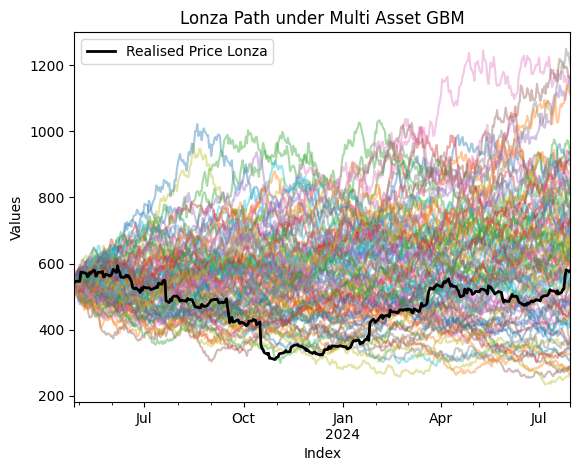

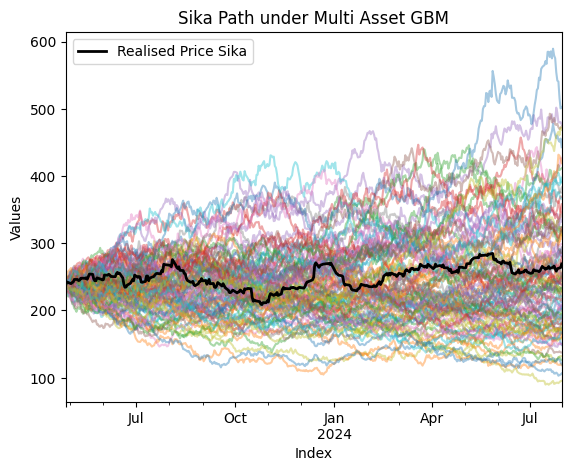

In [40]:
sim_data_combined = multi_asset_gbm_n_sims(plot = False, plotasset=True )
lonza_path = sim_data_combined.iloc[:, ::2]
sika_path = sim_data_combined.iloc[:, 1::2]


In [43]:
lonza_path.iloc[:,[4]]

,LONN.SW_sim
2023-04-27,543.878921
2023-04-28,571.268533
2023-04-29,578.371650
2023-04-30,575.797935
2023-05-01,567.442188
...,...
2024-07-26,416.586921
2024-07-27,425.759069
2024-07-28,425.556012
2024-07-29,427.623370


In [67]:
pf.payoff(lonza_path, sika_path, params_product)

c:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Dates.py:33: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  redemption_dates = pd.date_range(start=first_observation_date, end=enddate, freq='Q')
c:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Dates.py:33: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  redemption_dates = pd.date_range(start=first_observation_date, end=enddate, freq='Q')
c:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\payoff.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  terminalS1 = simS1[-1]
c:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\payoff.py

<function payoff.payoff(paths1, paths2, params)>

In [69]:
payoffs = pf.payoff(lonza_path, sika_path, params_product)
expected_payoff = np.mean(payoffs)
present_value = expected_payoff * np.exp(-(0.0018)* 60)

# Output the present value
print(f"The present value of the product is: {present_value:.2f}")

c:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Dates.py:33: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  redemption_dates = pd.date_range(start=first_observation_date, end=enddate, freq='Q')
c:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Dates.py:33: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  redemption_dates = pd.date_range(start=first_observation_date, end=enddate, freq='Q')
c:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\Dates.py:33: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  redemption_dates = pd.date_range(start=first_observation_date, end=enddate, freq='Q')
c:\Users\Admin\PycharmProjects\Simulation Techniques in Finance\.venv\MH4518\WY\payoff.py:64: FutureWarning: Series.__getitem__ treating keys as positions is de

KeyboardInterrupt: 